In [1]:
import torch
import torch.nn as nn
from torchvision.models import ResNet34_Weights
from torchvision.models import resnet34
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Resize, CenterCrop
from torchvision.transforms import v2
from tqdm import tqdm
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#Downloading the model
file_id = 'https://drive.google.com/file/d/1EtD0IW-mGIdNAyVX90UjLGKO-GfZSK6a/view?usp=sharing'
file_id ='https://drive.google.com/uc?id=' + file_id.split('/')[-2]
destination_dir = '/content/'

!mkdir -p $destination_dir
!gdown $file_id -O $destination_dir/model.zip
!unzip -q $destination_dir/model.zip -d $destination_dir

Downloading...
From: https://drive.google.com/uc?id=1EtD0IW-mGIdNAyVX90UjLGKO-GfZSK6a
To: /content/model.zip
100% 79.0M/79.0M [00:01<00:00, 50.7MB/s]


In [3]:
# function using model to extract feature + label tensors from dataset
def extract_features(model, loader, device):
    # set model to evaluation mode
    model.eval()

    features, labels = [], []

    # gradients not needed for inference
    with torch.no_grad():
        for image, label in tqdm(loader, desc="Extracting features"):
            # Forward pass through the model
            image = image.to(device)
            label = label.to(device)
            features_batch = model(image)
            # Flatten the features
            features_batch = features_batch.view(features_batch.size(0), -1)
            features.append(features_batch.cpu())
            labels.append(label)

    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

# function to create model pretrained on ImageNet only
def ImageNetModel(device):
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    model = model.to(device)
    return model

# function to find and plot KL divergence for a range of perplexity values
def find_perplexity(features, min_perplexity, max_perplexity, step, num_components):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    # array of perplexity values to test
    perplexity = np.arange(min_perplexity, max_perplexity, step)

    divergence = []

    # find the KL divergence for each perplexity value
    for i in perplexity:
        model = TSNE(n_components=num_components, init="pca", perplexity=i)
        reduced = model.fit_transform(features_np)
        divergence.append(model.kl_divergence_)

    # plot divergence
    fig = px.line(x=perplexity, y=divergence, markers=True)
    fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
    fig.update_traces(line_color="red", line_width=1)
    fig.show()

# function to perform tsne on features extracted and visualize results
def perform_tsne(features, perplexity, labels, title):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    labels = labels.cpu()

    # perform tsne
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, random_state=42)
    features_tsne = tsne.fit_transform(features_np)

    # plot results
    fig, ax = plt.subplots()
    scatter = ax.scatter(x=features_tsne[:, 0], y=features_tsne[:, 1], c=labels, alpha=0.3)
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.add_artist(legend1)
    plt.title(title)
    plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load custom model
model1 = resnet34(num_classes=3).to(device)
model1.load_state_dict(torch.load("model.pth", map_location=device))

# load ImageNet model
model2 = ImageNetModel(device)

models = {
    # remove final classification layer in each model
    "Custom Model": nn.Sequential(*list(model1.children())[:-1]),
    "ImageNet Model": nn.Sequential(*list(model2.children())[:-1])
}

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 71.1MB/s]


In [6]:
#Downloading the datasets 2 and 3
file_id = 'https://drive.google.com/file/d/1zzl5T2dTmDJsJFWg-WINNaBu3eM_-Fa_/view?usp=sharing'
file_id ='https://drive.google.com/uc?id=' + file_id.split('/')[-2]
destination_dir = '/content/'

!mkdir -p $destination_dir
!gdown $file_id -O $destination_dir/dataset2.zip
!unzip -q $destination_dir/dataset2.zip -d $destination_dir


file_id = 'https://drive.google.com/file/d/1a_ugP7MB2Ykf_2WaNkDgWMVpF2zRA-HS/view?usp=sharing'
file_id ='https://drive.google.com/uc?id=' + file_id.split('/')[-2]
destination_dir = '/content/'

!mkdir -p $destination_dir
!gdown $file_id -O $destination_dir/dataset3.zip
!unzip -q $destination_dir/dataset3.zip -d $destination_dir

Downloading...
From: https://drive.google.com/uc?id=1zzl5T2dTmDJsJFWg-WINNaBu3eM_-Fa_
To: /content/dataset2.zip
100% 123M/123M [00:01<00:00, 96.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a_ugP7MB2Ykf_2WaNkDgWMVpF2zRA-HS
To: /content/dataset3.zip
100% 278M/278M [00:03<00:00, 76.6MB/s]


In [7]:
# define transformations according to ImageNet preprocessing
ImageNet_transform = v2.Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# define transformations according to custom model's preprocessing
custom_transform = v2.Compose([
    ToTensor(),
    Normalize([0.7621, 0.5239, 0.7111], [0.0066, 0.0096, 0.0063])
])

# load transformed Dataset 2 and 3 for each model
data_loaders = {
    "Custom Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='Dataset 2/Prostate Cancer', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='Dataset 3/Animal Faces', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4)
    },
    "ImageNet Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='Dataset 2/Prostate Cancer', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='Dataset 3/Animal Faces', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4)
    },
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# apply feature extractionfor 4 scenarios
# custom model on Dataset 2, custom model on Dataset 3
# ImageNet model on Dataset 2, ImageNet model on Dataset 3
extracted_features = {}
for model_name, model in models.items():
    for dataset_name, dataloader in data_loaders[model_name].items():
        features, labels = extract_features(model, dataloader, device)
        key = model_name + "_" + dataset_name
        extracted_features[key] = {
            "features" : features,
            "labels" : labels
        }

Extracting features: 100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


In [9]:
X = extracted_features["Custom Model_Prostate Cancer"]["features"].detach().cpu().numpy()
y = extracted_features["Custom Model_Prostate Cancer"]["labels"].detach().cpu().numpy()
Cancer_Classes = ["Gland", "NonGland", "Tumour"]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)

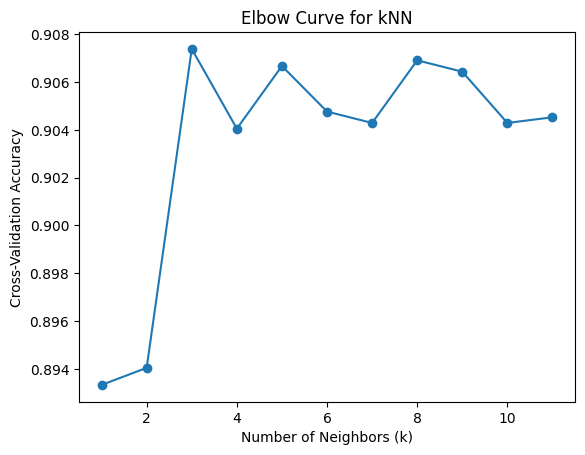


Optimal number of neighbors (k): 3


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define a range of k values to test
k_values = np.arange(1, 12)  # You can adjust the range based on your preferences

# List to store cross-validation scores for each k
cv_scores = []

# Perform k-fold cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    cv_scores.append(scores.mean())

# Plot the elbow curve
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Elbow Curve for kNN')
plt.show()

# Find the optimal k (the one with the highest accuracy)
optimal_k = k_values[np.argmax(cv_scores)]
print(f'\nOptimal number of neighbors (k): {optimal_k}')

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 4200 samples in 0.001s...
[t-SNE] Computed neighbors for 4200 samples in 0.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4200
[t-SNE] Computed conditional probabilities for sample 2000 / 4200
[t-SNE] Computed conditional probabilities for sample 3000 / 4200
[t-SNE] Computed conditional probabilities for sample 4000 / 4200
[t-SNE] Computed conditional probabilities for sample 4200 / 4200
[t-SNE] Mean sigma: 0.773923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.717918
[t-SNE] KL divergence after 1000 iterations: 1.253354


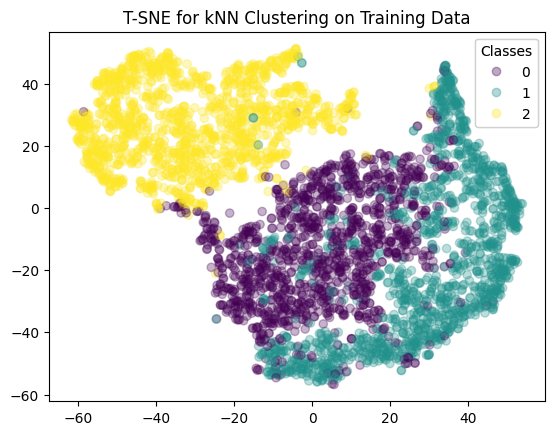

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 1800 samples in 0.001s...
[t-SNE] Computed neighbors for 1800 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1800
[t-SNE] Computed conditional probabilities for sample 1800 / 1800
[t-SNE] Mean sigma: 0.955009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.553543
[t-SNE] KL divergence after 1000 iterations: 0.907941


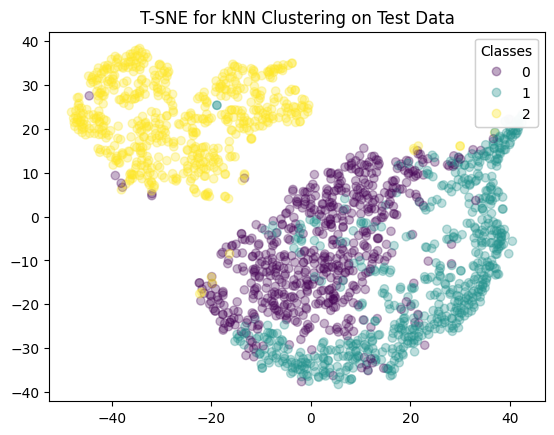

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Choose the number of clusters (number of neighbors in kNN)
num_neighbors = 3

# Create and fit the kNN model
knn = KNeighborsClassifier(n_neighbors=num_neighbors)
knn.fit(X_train, y_train)  # y_train is the ground truth labels for supervised learning

# Predict cluster labels for the training set
cluster_labels_train = knn.predict(X_train)

# Visualize the clustering results using TSNE
perform_tsne(torch.tensor(X_train), perplexity=35, labels=torch.tensor(cluster_labels_train), title="T-SNE for kNN Clustering on Training Data")

# Similar steps for the test set if needed
cluster_labels_test = knn.predict(X_test)
perform_tsne(torch.tensor(X_test), perplexity=35, labels=torch.tensor(cluster_labels_test), title="T-SNE for kNN Clustering on Test Data")


              precision    recall  f1-score   support

       Gland       0.93      0.90      0.92      1380
    NonGland       0.92      0.94      0.93      1398
      Tumour       0.98      0.99      0.98      1422

    accuracy                           0.94      4200
   macro avg       0.94      0.94      0.94      4200
weighted avg       0.94      0.94      0.94      4200



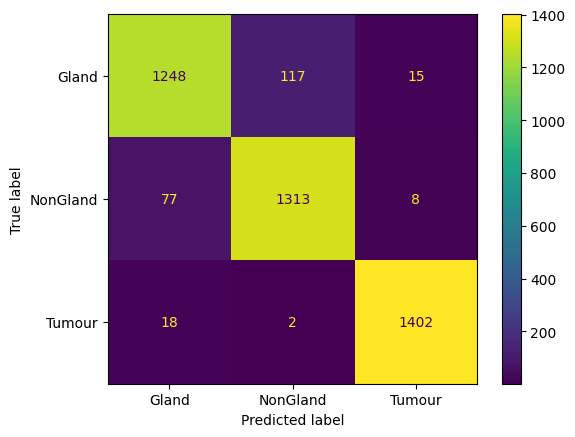

In [22]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import classification_report

print(classification_report(y_train, cluster_labels_train, target_names=Cancer_Classes))

cm = confusion_matrix(y_train, cluster_labels_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Cancer_Classes)
disp.plot();

              precision    recall  f1-score   support

       Gland       0.90      0.85      0.88       620
    NonGland       0.87      0.91      0.89       602
      Tumour       0.98      0.98      0.98       578

    accuracy                           0.91      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.91      0.91      0.91      1800



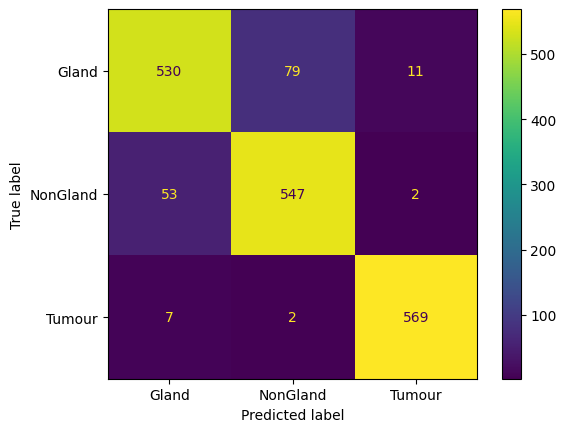

In [21]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import classification_report

print(classification_report(y_test, cluster_labels_test, target_names=Cancer_Classes))
cm = confusion_matrix(y_test, cluster_labels_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Cancer_Classes)
disp.plot();